## Versión 2.0

In [1]:
import os
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from utils import *
import io
import contextlib
import sys



---
***Lectura de ficheros***

---

In [2]:


# Directorio donde están los archivos Excel
directorio = r"C:\Users\Usuario\Documents\Github\IECA\Datos"  # Reemplaza esto con la ruta real

# Patrón para extraer la fecha del nombre del archivo
patron_fecha = r'Envío_(\d{2})_(\d{2})_(\d{4})'

nombre_hoja_mensual = 'Series_mens_vol_y_desest'  # nombre de la hoja en el archivo Excel
nombre_hoja_trimestre = 'Serie trim_vol_desest_Índice'  # nombre de la hoja en el archivo Excel

# Diccionario para almacenar los DataFrames
dfs_m = {}
dfs_q = {}

# Iterar sobre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.xlsx'):  # Asumiendo que son archivos Excel
        ruta_completa = os.path.join(directorio, archivo)
        
        # Extraer la fecha del nombre del archivo
        match = re.search(patron_fecha, archivo)
        if match:
            dia, mes, anio = match.groups()
            fecha = datetime(int(anio), int(mes), int(dia)).strftime('%Y-%m-%d')
            
            # Leer el archivo Excel
            df_mens = pd.read_excel(ruta_completa, nombre_hoja_mensual)
            df_mens['fecha'] = pd.to_datetime(df_mens['fecha']).dt.strftime('%m-%y')
            # Establece la columna 'fecha' como el índice del DataFrame
            df_mens.set_index('fecha', inplace=True)
            df_mens = df_mens.rolling(window=3).mean()
            df_mens = df_mens[2:]
            df_trims = pd.read_excel(ruta_completa, nombre_hoja_trimestre)
            df_trims['fecha'] = pd.to_datetime(df_trims['fecha']).dt.strftime('%m-%y')
            # Establece la columna 'Fecha' como el índice del DataFrame
            df_trims.set_index('fecha', inplace=True)

            #Estacionaridad de series 

            df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(df_mens)
            df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(df_trims)

            df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
            df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = df_mens['Total afiliados SS Total - Andalucía'].diff(3)

            endog_m = df_estacionario_mensual
            endog_q = df_estacionario_trimestral*100

                        
            #Hago merge con datos mensuales "trimestralizados" y el trimestral

            # Convertir el índice del DataFrame mensual a formato de fecha y hora
            endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y')
            # Convertir el índice del DataFrame mensual a formato de fecha y hora
            endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y')

            endog_q.index = endog_q.index.to_period('Q')
            endog_m.index = endog_m.index.to_period('M')
         
            # Almacenar el DataFrame en el diccionario con la fecha como clave
            dfs_m[fecha] = endog_m
            dfs_q[fecha] = endog_q

            
ficheros = list(dfs_m.keys())

In [3]:
ficheros

['2023-12-02', '2023-12-03', '2023-12-04']

SELECCIÓN

In [4]:

mejores_regresores = ['Importaciones de bienes - Andalucía', 
                        'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía', 
                        'Total afiliados SS Total - Andalucía', 
                        'Matriculación de turismos - Andalucía', 
                        'Consumo de gasolina y gasóleo', 
                        'Cifra negocios del sector servicios - Andalucía'
                        ]


endog_m_c = dfs_m[ficheros[0]][mejores_regresores]



endog_q=dfs_q[ficheros[0]][['pib']]

mod = sm.tsa.DynamicFactorMQ(endog_m_c, 
                            endog_quarterly=endog_q, 
                            factor_orders = 2, 
                            factors=2,
                            factor_multiplicities=1)
res = mod.fit(maxiter=1000)

In [12]:
# Tu código para crear y ajustar el modelo


# Abrir un archivo de texto para escribir
with open(r"C:\Users\Usuario\Documents\Github\IECA\output\resultados_estimaciones.txt", 'w') as f:
    # Escribir una cabecera
    f.write("Resultados de las estimaciones\n")
    f.write("=============================\n\n")

    
    f.write("Estimación del modelo DFMQ\n\n")
    f.write("=============================\n\n")

    # Capturar el output del summary() en una variable
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout

    print(res.summary())

    sys.stdout = old_stdout
    summary_output = new_stdout.getvalue()

    # Escribir el summary en el archivo
    f.write(summary_output)

    # Puedes añadir más información si lo deseas
    f.write("\nInformación adicional:\n")
    f.write(f"AIC: {res.aic}\n")
    f.write(f"BIC: {res.bic}\n")


    # Añadir información adicional
    f.write("\nInformación adicional:\n")
    f.write(f"AIC: {res.aic}\n")
    f.write(f"BIC: {res.bic}\n")

    # Añadir los coeficientes de determinación
    f.write("\nCoeficientes de determinación (R^2):\n")
    
    f.write("===================================\n\n")
    rsquared = res.get_coefficients_of_determination(method='individual')
    
    top_ten = []
    for factor_name in rsquared.columns[:6]:
        top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                           .iloc[:30].round(2).reset_index())
        top_factor.columns = ['Variable', 'R^2']
        
        # Guardar para el DataFrame combinado
        top_factor.columns = pd.MultiIndex.from_product([
            [f'Top ten variables explained by {factor_name}'],
            ['Variable', r'$R^2$']])
        top_ten.append(top_factor)

    # Crear y escribir el DataFrame combinado
    f.write("\nTabla combinada de top variables XXXX por factor:\n")
    combined_df = pd.concat(top_ten, axis=1)
    f.write(combined_df.to_string())

print("Los resultados han sido guardados en 'resultados_estimaciones.txt'")

Los resultados han sido guardados en 'resultados_estimaciones.txt'


---
***Coeficiente de determinación***

---

In [13]:
rsquared = res.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:6]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:30].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by 0        \
                                            Variable $R^2$   
0                                                pib  0.91   
1    Cifra negocios del sector servicios - Andalucía  0.88   
2                      Consumo de gasolina y gasóleo  0.88   
3              Matriculación de turismos - Andalucía  0.80   
4               Total afiliados SS Total - Andalucía  0.54   
5                Importaciones de bienes - Andalucía  0.27   
6  Liquidación de presupuestos de la Junta de And...  0.01   

                    Top ten variables explained by 1        
                                            Variable $R^2$  
0              Matriculación de turismos - Andalucía  0.32  
1                      Consumo de gasolina y gasóleo  0.29  
2                                                pib  0.18  
3    Cifra negocios del sector servicios - Andalucía  0.13  
4                Importaciones de bienes - Andalucía  0.04  
5  Liquidación de presupuestos de la Junta de And...  0.03  
6               Total afiliados SS Total - Andalucía  0.01

In [14]:
rsquared

,0,1
Importaciones de bienes - Andalucía,0.265102,0.038530
Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía,0.006396,0.027598
Total afiliados SS Total - Andalucía,0.538907,0.010131
Matriculación de turismos - Andalucía,0.801454,0.318033
Consumo de gasolina y gasóleo,0.884090,0.290861
Cifra negocios del sector servicios - Andalucía,0.884235,0.133540
pib,0.905906,0.176879


In [15]:
r2_pib = rsquared.loc['pib'].max()

In [16]:
r2_pib

0.9059064582515466

In [6]:
# Archivo vintages
vintage_results = {ficheros[0]: res}  #aquí la fecha de inicio

In [7]:


start = '2000'

# Apply our results to the remaining vintages
for vintage in ficheros[1:]:
    print(vintage)

    # Get updated data for the vintage
    updated_endog_m = dfs_m[vintage][mejores_regresores].loc[start:, :]
    updated_endog_q = dfs_q[vintage][['pib']].loc[start:, :]

    # Get updated results for for the vintage
    vintage_results[vintage] = res.apply(
        updated_endog_m, endog_quarterly=updated_endog_q, retain_standardization=False)

2023-12-03
2023-12-04


In [8]:
# Create forecasts results objects, through the end of 20201
prediction_results = res.get_prediction(start='2006-01', end='2023-12')

variables = ['pib']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]
predictionGDP= point_predictions.resample('Q').last()

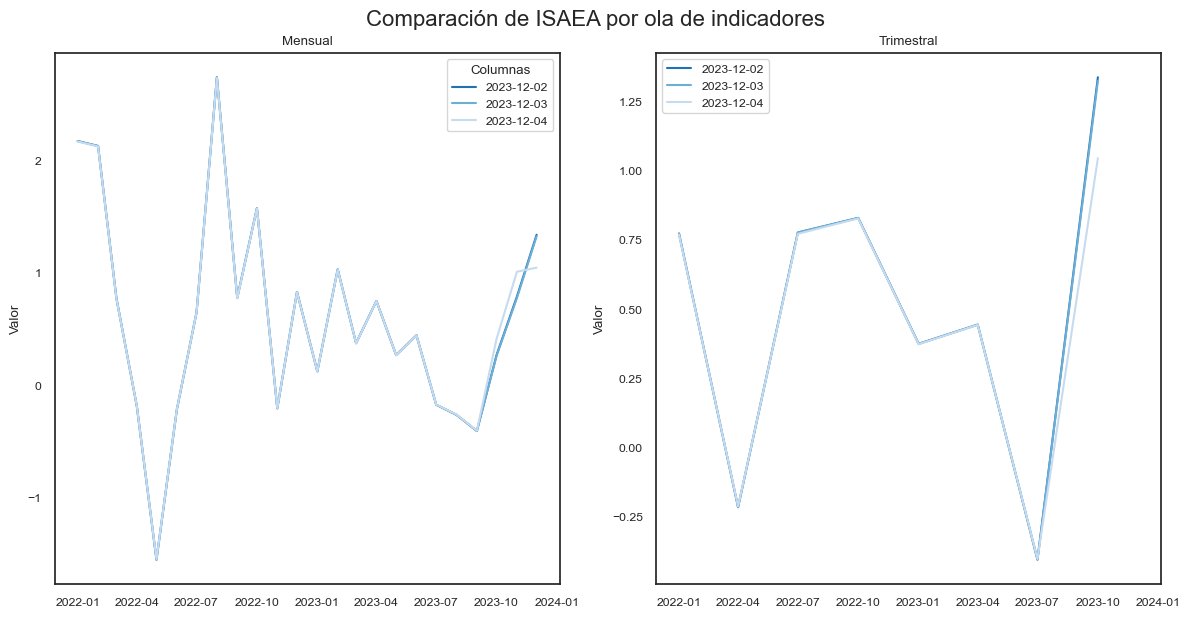

In [9]:
# Compute forecasts for each vintage
forecasts_m = {vintage: res.get_prediction(start='2006-01', end='2023-12').predicted_mean['pib']
             for vintage, res in vintage_results.items()}

forecast_mensuales = pd.DataFrame(forecasts_m)

# Compute forecasts for each vintage
forecasts_q = {vintage: res.get_prediction(start='2006-01', end='2023-12').predicted_mean['pib']
                         .resample('Q').last()
             for vintage, res in vintage_results.items()}

forecast_trimestrales = pd.DataFrame(forecasts_q)

# Primero, convierte el índice de períodos a timestamps
forecast_mensuales.index = forecast_mensuales.index.to_timestamp()

# Luego, si es necesario, convierte a datetime
forecast_mensuales.index = pd.to_datetime(forecast_mensuales.index)


# Primero, convierte el índice de períodos a timestamps
forecast_trimestrales.index = forecast_trimestrales.index.to_timestamp()

# Luego, si es necesario, convierte a datetime
forecast_trimestrales.index = pd.to_datetime(forecast_trimestrales.index)



# Filtrar el DataFrame para mostrar solo desde enero de 2020 en adelante
forecast_mensuales_f = forecast_mensuales.loc['2022-01':]
forecast_trimestrales_f = forecast_trimestrales.loc['2022-01':]

# Crear una paleta de colores en degradado de más claro a más oscuro
n_columns_mensual = forecast_mensuales_f.shape[1]
palette_mensual = sns.color_palette("Blues_r", n_colors=n_columns_mensual)

n_columns_trimestral = forecast_trimestrales_f.shape[1]
palette_trimestral = sns.color_palette("Blues_r", n_colors=n_columns_trimestral)

# Configurar el estilo de Seaborn y quitar el grid
sns.set(style="white")
sns.set_context("talk")
sns.set_context("notebook", font_scale=0.8)  # Ajustar el tamaño del texto aquí

# Crear una figura y ejes con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Dibujar cada columna con el color correspondiente en el primer subplot
for i, col in enumerate(forecast_mensuales_f.columns):
    sns.lineplot(data=forecast_mensuales_f, x=forecast_mensuales_f.index, y=col, color=palette_mensual[i], label=col, ax=ax1)

# Configurar el título y las etiquetas de los ejes para el primer subplot
ax1.set_title('Mensual')
ax1.set_ylabel('Valor')
ax1.legend(title='Columnas')

# Dibujar cada columna con el color correspondiente en el segundo subplot
for i, col in enumerate(forecast_trimestrales_f.columns):
    sns.lineplot(data=forecast_trimestrales_f, x=forecast_trimestrales_f.index, y=col, color=palette_trimestral[i], label=col, ax=ax2)

# Configurar el título y las etiquetas de los ejes para el segundo subplot
ax2.set_title('Trimestral')
ax2.set_ylabel('Valor')

# Ajustar el espacio entre los subplots
plt.tight_layout()


# Agregar un título general al conjunto de gráficos
plt.suptitle('Comparación de ISAEA por ola de indicadores', fontsize=16, y=1.02)

# Mostrar la figura
plt.show()

In [10]:
forecast_mensuales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indicador_mensual.csv", sep=";")
forecast_trimestrales.to_csv(r"C:\Users\Usuario\Documents\Github\IECA\output\indicador_trimestral.csv", sep=";")

---
***Noticias e impacto***

---

In [82]:
news_results = {}

impact_date = '2023-12'

for i in range(1, len(ficheros)):
    vintage = ficheros[i]
    prev_vintage = ficheros[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (February 2020) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable='pib',
        comparison_type='previous').details_by_impact

dfs = []    

# Guardar cada DataFrame en un archivo CSV
for name, df in news_results.items():
    output_file = os.path.join(r"C:\Users\Usuario\Documents\Github\IECA\output\Nowcasting", f'resultados_{name}.csv')
    df['fichero']=name
    df.to_csv(output_file, sep=";")
    dfs.append(df)
    total = pd.concat(dfs)
total = total.reset_index()

# Utilizando pivot_table para reorganizar los datos
df_transformed = total.pivot_table(index='fichero', columns='updated variable', values='impact')

# Resetear el índice para tener 'fichero' como una columna
df_transformed.reset_index(inplace=True)

# Cambiar el nombre de la columna 'fichero' a 'grupos'
df_transformed.rename(columns={'fichero': 'grupos'}, inplace=True)
df_transformed.fillna(0)

# Tomar la última fila del DataFrame original
ultima_fila = forecast_mensuales.iloc[-1]
ultima_fila = ultima_fila.to_frame()
ultima_fila.reset_index(inplace=True)
nombres = ['grupos', 'point estimate']
ultima_fila.columns = nombres

df_transformed = pd.merge(df_transformed, ultima_fila, on='grupos', how='right').fillna(0)
df_transformed.drop(columns=['point estimate'], inplace=True)

In [85]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   grupos                               3 non-null      object 
 1   Consumo de gasolina y gasóleo        3 non-null      float64
 2   Importaciones de bienes - Andalucía  3 non-null      float64
 3   pib                                  3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 120.0+ bytes


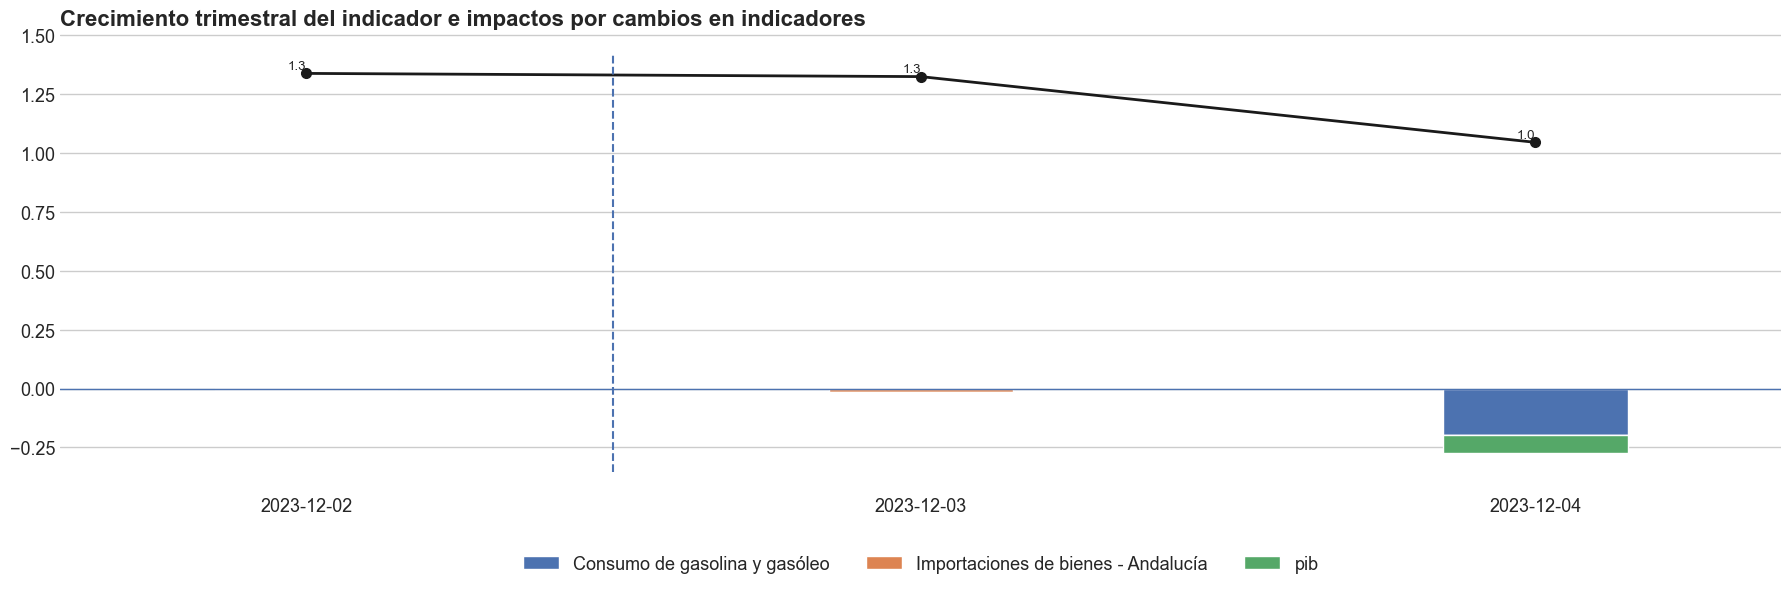

In [84]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(18, 6))

    # Stacked bar plot showing the impacts by group
    df_transformed.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax);

    # Line plot showing the forecast for real GDP growth in 2020Q4 for each vintage
    x = np.arange(len(ultima_fila['point estimate']))
    ax.plot(x, ultima_fila['point estimate'], marker='o', color='k', markersize=7, linewidth=2)
    for i,j in zip(x,ultima_fila['point estimate']):
        ax.annotate(str(f"{j:,.1f}"),xy=(i-0.03,j+0.02))
    ax.hlines(0, -1, len(df_transformed) + 1, linewidth=1)

    # x-ticks
    labels = df_transformed.grupos
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)

    # y-ticks
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Crecimiento trimestral del indicador e impactos por cambios en indicadores', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]
    
    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 0, linestyles='--')
    ax.annotate('Base', (-0.2, 1.55), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout();